In [9]:
# all this code was borrowed from 
# https://towardsdatascience.com/how-i-used-machine-learning-to-automatically-hand-draw-any-picture-7d024d0de997
import cv2;
from matplotlib import pyplot as plt
import numpy as np
import pyautogui as pg
import kdtree
import operator

class AutoDraw(object):
    def __init__(self, name, blur = 0):
        # Tunable parameters
        self.detail = 1
        self.scale = 7/12
        self.sketch_before = False
        self.with_color = True
        self.num_colors = 10
        self.outline_again = False

        # Load Image. Switch axes to match computer screen
        self.img = cv2.imread(name)
        self.blur = blur
        self.img = np.swapaxes(self.img, 0, 1)
        self.img_shape = self.img.shape

#         self.dim = pg.size()

        self.dim = (100, 100)

        # Scale to draw inside part of screen
        self.startX = ((1 - self.scale) / 2)*self.dim[0] 
        self.startY = ((1 - self.scale) / 2)*self.dim[1] 
        self.dim = (self.dim[0] * self.scale, self.dim[1] * self.scale)

        # fit the picture into this section of the screen
        if self.img_shape[1] > self.img_shape[0]:
            # if it's taller that it is wide, truncate the wide section
            self.dim = (int(self.dim[1] * (self.img_shape[0] / self.img_shape[1])), self.dim[1])
        else:
            # if it's wider than it is tall, truncate the tall section
            self.dim = (self.dim[0], int(self.dim[0] *(self.img_shape[1] / self.img_shape[0])))

        # Get dimension to translate picture. Dimension 1 and 0 are switched due to comp dimensions
        ratio = self.img.shape[0] / self.img.shape[1]
        pseudo_x = int(self.img.shape[1] * self.detail)
        self.pseudoDim = (pseudo_x, int(pseudo_x * ratio))
        
          # Initialize directions for momentum when creating path
        self.maps = {0: (1, 1), 1: (1, 0), 2: (1, -1), 3: (0, -1), 4: (0, 1), 5: (-1, -1), 6: (-1, 0), 7: (-1, 1)}
        self.momentum = 1
        self.curr_delta = self.maps[self.momentum]

        # Create Outline
        self.drawing = self.process_img(self.img)
        plt.imshow(self.drawing)
        plt.show()

    def rescale(self, img, dim):
        resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        return resized

    def translate(self, coord):
        ratio = (coord[0] / self.pseudoDim[1], coord[1] / self.pseudoDim[0]) # this is correct
        deltas = (int(ratio[0] * self.dim[0]), int(ratio[1] * self.dim[1]))
        return self.startX + deltas[0], self.startY + deltas[1]
    
    def process_img(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if self.blur == 2:
            gray = cv2.GaussianBlur(gray, (9, 9), 0)
            canny = cv2.Canny(gray, 25, 45)
        elif self.blur == 1:
            gray = cv2.GaussianBlur(gray, (3, 3), 0)
            canny = cv2.Canny(gray, 25, 45)
        else:  # no blur
            canny = cv2.Canny(gray, 50, 75)
        canny = self.rescale(canny, self.pseudoDim)
        r, res = cv2.threshold(canny, 50, 255, cv2.THRESH_BINARY_INV)

        return res
    
    def drawOutline(self):
        indices = np.argwhere(self.drawing < 127).tolist()  # get the black colors
        index_tuples = map(tuple, indices)

        self.hashSet = set(index_tuples)
        self.KDTree = kdtree.create(indices)
#         self.KDTree = KDTree(indices)
        self.commands = []
        self.curr_pos = (0, 0)
        point = self.translate(self.curr_pos)
        self.commands.append(point)

        print('Please change pen to thin and color to black.')
        input("Press enter once ready")
        print('')

        # DRAW THE BLACK OUTLINE
        self.createPath()
        print(self.commands)
#         input("Ready! Press Enter to draw")
#         print('5 seconds until drawing beings')
#         time.sleep(5)

#         self.execute(self.commands)

    def createPath(self):
        # check for closest point. Go there. Add click down. Change curr. Remove from set and tree. Then, begin
        new_pos = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#         print(self.curr_pos[0)
#         new_pos = tuple(self.KDTree.query(self.curr_pos)[0].data)
        self.commands.append(new_pos)
        self.commands.append("DOWN")
        self.curr_pos = new_pos
        self.KDTree = self.KDTree.remove(list(new_pos))
        self.hashSet.remove(new_pos)

        while len(self.hashSet) > 0:
            prev_direction = self.momentum
            candidate = self.checkMomentum(self.curr_pos)
            if self.isValid(candidate):
                new = tuple(map(operator.add, self.curr_pos, candidate))
                new_pos = self.translate(new)
                if prev_direction == self.momentum and type(self.commands[-1]) != str:  # the direction didn't change
                    self.commands.pop()
                self.commands.append(new_pos)
            else:
                self.commands.append("UP")
                new = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#                 new = tuple(self.KDTree.query(self.curr_pos)[0].data)
                new_pos = self.translate(new)
                self.commands.append(new_pos)
                self.commands.append("DOWN")
            self.curr_pos = new
            self.KDTree = self.KDTree.remove(list(new))
            self.hashSet.remove(new)
#             print('Making path...number points left: ', len(self.hashSet))
        return

    def isValid(self, delta):
        return len(delta) == 2

    def checkMomentum(self, point):
        # Returns best next relative move w.r.t. momentum and if in hashset
        self.curr_delta = self.maps[self.momentum]
        moments = self.maps.values()
        deltas = [d for d in moments if (tuple(map(operator.add, point, d)) in self.hashSet)]
        deltas.sort(key=self.checkDirection, reverse=True)
        if len(deltas) > 0:
            best = deltas[0]
            self.momentum = [item[0] for item in self.maps.items() if item[1] == best][0]
            return best
        return [-1]

    def checkDirection(self, element):
        return self.dot(self.curr_delta, element)

    def dot(self, pt1, pt2):
        pt1 = self.unit(pt1)
        pt2 = self.unit(pt2)
        return pt1[0] * pt2[0] + pt1[1] * pt2[1]

    def unit(self, point):
        norm = (point[0] ** 2 + point[1] ** 2)
        norm = np.sqrt(norm)
        return point[0] / norm, point[1] / norm

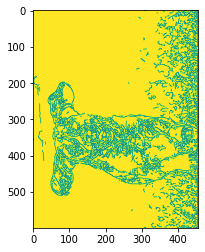

Please change pen to thin and color to black.
Press enter once ready

[(20.833333333333332, 20.833333333333332), (182, 8), 'DOWN', (37.83333333333333, 20.833333333333332), (37.83333333333333, 20.833333333333332), (37.83333333333333, 20.833333333333332), (38.83333333333333, 20.833333333333332), (38.83333333333333, 20.833333333333332), (38.83333333333333, 20.833333333333332), (39.83333333333333, 20.833333333333332), (39.83333333333333, 20.833333333333332), (39.83333333333333, 20.833333333333332), (40.83333333333333, 20.833333333333332), (40.83333333333333, 21.833333333333332), (39.83333333333333, 21.833333333333332), 'UP', (40.83333333333333, 21.833333333333332), 'DOWN', 'UP', (40.83333333333333, 21.833333333333332), 'DOWN', (40.83333333333333, 21.833333333333332), (40.83333333333333, 21.833333333333332), 'UP', (40.83333333333333, 21.833333333333332), 'DOWN', (41.83333333333333, 21.833333333333332), (41.83333333333333, 21.833333333333332), (41.83333333333333, 21.833333333333332), (41.833

In [10]:
drawing = AutoDraw("./dog.jpeg")
drawing.drawOutline()


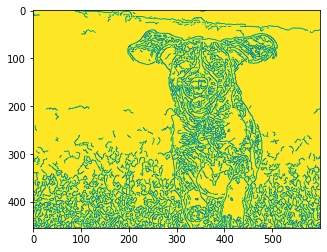